# DL-based Stock Price Prediction Notebook
Starting with an LSTM-based predictor, inspired by https://github.com/jinglescode/time-series-forecasting-pytorch/tree/main (also on https://www.alphavantage.co/stock-prediction-deep-neural-networks-lstm/)

In [116]:
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Literal

from prompt_toolkit.shortcuts import set_title
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

In [117]:
ROOT = Path().resolve().parent
DATA = ROOT / "data"
DAILY_PRICES = DATA / "daily_trading_prices"
MINUTELY_PRICES = DATA / "minutely_trading_prices"

## LSTM Development

### Parameters

In [118]:
# data import parameters:
price_file_path = MINUTELY_PRICES / "2025-05-08 08_56_20 DAX 4. close price data 2021-07-01 to 2025-04-30.csv"  # DAILY_PRICES / "20250505 14_56_24 ^GDAXI Close price data 1987-12-30 to 2025-05-05.csv"
price_column = '4. close'  # 'Close'
date_column = 'date'  # 'Datetime' 
sampling_rate = 'minute'

# data preparation parameters:
validation_split = 0.2
rolling_window_size = 20
batch_size = 32  # number of data_points to be used during training
# increase if training is stable but slow
# decrease if generalization is poor

# model parameters:
model_input_size = 1
hidden_lstm_layer_size = 16
num_lstm_layers = 2
dropout = 0.35  # regularizer to prevent overfitting
use_final_hidden_state = True
init_weights = True
use_mps_if_available = False  # with this computer the CPU has often been faster than Metal Performance Shaders

# training parameters:
loss_criterion = nn.MSELoss()
n_epochs = 200
scheduler_to_use = 'plateau'
step_scheduler_step_size = 40
plateau_scheduler_factor = 0.2
early_stopping_patience = 15  # if 0 doesn't utilise early stopping
initial_learning_rate = 0.005

### Data Loading

In [119]:
price_file = pd.read_csv(price_file_path)
price_file.dropna(axis=0, inplace=True)
price_file[date_column] = pd.to_datetime(price_file[date_column])
price_file[price_column] = price_file[price_column].astype(float) 

price_series = price_file.set_index(date_column)[price_column]
price_series

date
2021-07-01 09:30:00    30.7519
2021-07-01 09:57:00    30.6909
2021-07-01 10:24:00    30.8433
2021-07-01 11:19:00    30.6970
2021-07-01 11:48:00    30.7131
                        ...   
2025-04-30 17:13:00    41.9000
2025-04-30 18:00:00    41.5582
2025-04-30 18:09:00    41.5100
2025-04-30 19:20:00    41.5100
2025-04-30 19:44:00    43.5800
Name: 4. close, Length: 28634, dtype: float64

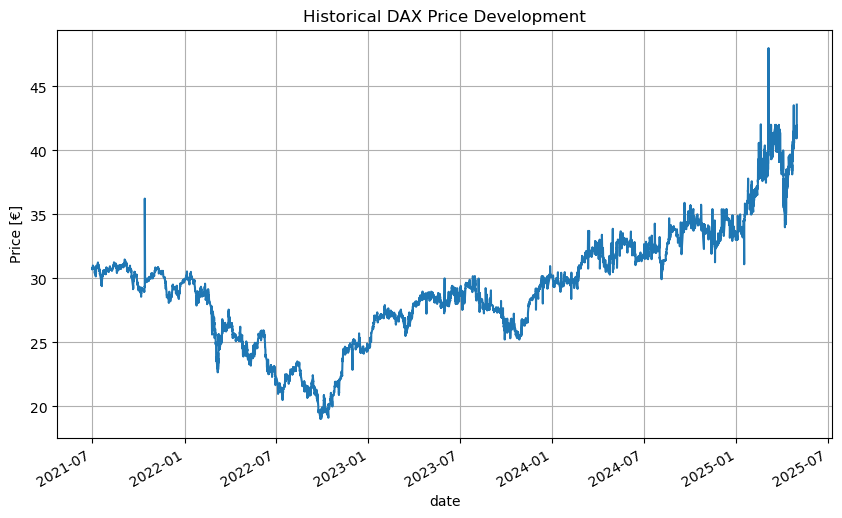

In [120]:
price_series.plot(ylabel='Price [€]', title='Historical DAX (ETF) Price Development', figsize=(10, 6))
plt.grid()

### Data Preparation

#### Normalisation
Scaling the data is important for convergence during model training. We utilise the *normalisation* technique.

In [121]:
class Normaliser():
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        """ Normalise an array of values. """
        self.mu = np.mean(x, axis=0)
        self.sd = np.std(x, axis=0)
        normalized_x = (x - self.mu)/self.sd
        return normalized_x

    def inverse_transform(self, x):
        """ Reverse-transform an array of normalised values. """
        if self.sd is None: raise AttributeError("Please use fit_transform first so this instance remembers the respective std. and mean values!")
        return (x*self.sd) + self.mu

In [122]:
normaliser = Normaliser()
normalised_price_series = normaliser.fit_transform(price_series)
normalised_price_series

date
2021-07-01 09:30:00   -0.324271
2021-07-01 09:57:00   -0.333746
2021-07-01 10:24:00   -0.310074
2021-07-01 11:19:00   -0.332799
2021-07-01 11:48:00   -0.330298
                         ...   
2025-04-30 17:13:00    1.407332
2025-04-30 18:00:00    1.354241
2025-04-30 18:09:00    1.346754
2025-04-30 19:20:00    1.346754
2025-04-30 19:44:00    1.668281
Name: 4. close, Length: 28634, dtype: float64

#### Training Data
Split a share of the data (with the most recent datapoints) for model validation. 

We will train the model to predict the (rolling_window_size+1)th price based on the past (rolling_window_size) prices.

In [123]:
# sliding window view as matrix: last column are current prices, 1st to (rolling-window-size - 1)th column are retrospective prices
# other possibility but apparently less safe:
#   np.lib.stride_tricks.as_strided(X, shape=(len(X) - rolling_window_size + 1, rolling_window_size), strides=(X.strides[0], X.strides[0]))[:-1]
X = np.lib.stride_tricks.sliding_window_view(normalised_price_series.to_numpy(), window_shape=rolling_window_size)[:-1]  # last row (latest value) is removed (because contained only in target values)
X

array([[-0.3242714 , -0.33374636, -0.3100745 , ..., -0.32142892,
        -0.32284239, -0.32214342],
       [-0.33374636, -0.3100745 , -0.33279887, ..., -0.32284239,
        -0.32214342, -0.31996884],
       [-0.3100745 , -0.33279887, -0.3302981 , ..., -0.32214342,
        -0.31996884, -0.31858643],
       ...,
       [ 1.34209435,  1.33432799,  1.34131771, ...,  1.42286449,
         1.40733177,  1.35424094],
       [ 1.33432799,  1.34131771,  1.34131771, ...,  1.40733177,
         1.35424094,  1.34675417],
       [ 1.34131771,  1.34131771,  1.33743453, ...,  1.35424094,
         1.34675417,  1.34675417]], shape=(28614, 20))

In [124]:
# target values are current prices, here the first 20 values have to be removed because of the moving window:
Y = normalised_price_series.to_numpy()[rolling_window_size:]
Y

array([-0.31996884, -0.31858643, -0.32214342, ...,  1.34675417,
        1.34675417,  1.66828147], shape=(28614,))

Using last 20.0% of data for validation. Other data for training.


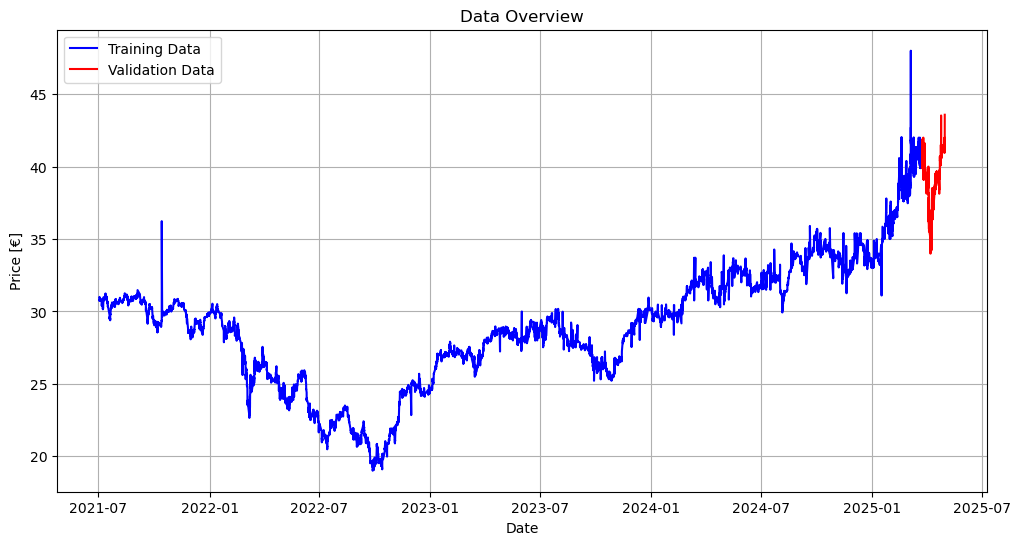

In [125]:
# split prices into training and validation data:
print(f"Using last {100 * validation_split}% of data for validation. Other data for training.")
validation_split_index = int(X.shape[0] * (1-validation_split))
X_train = X[:validation_split_index]
X_val = X[validation_split_index:]
Y_train = Y[:validation_split_index]
Y_val = Y[validation_split_index:]

# retrieve y-dates for plotting:
dates = normalised_price_series.index.to_numpy()[rolling_window_size:]
dates_train = dates[:validation_split_index]
dates_val = dates[validation_split_index:]

# plot result:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(dates_train, normaliser.inverse_transform(Y_train), label='Training Data', color='blue')
ax.plot(dates_val, normaliser.inverse_transform(Y_val), label='Validation Data', color='red')
ax.set_xlabel('Date')
ax.set_ylabel('Price [€]')
ax.set_title('Data Overview')
ax.grid(True)
ax.legend()

#### Pytorch Dataset and DataLoader

In [126]:
from typing import Union

class TimeSeriesDataset(Dataset):
    """ Time-series dataset class based on torch.utils.data.Dataset compatible torch.utils.data.DataLoader """
    def __init__(self,
                 x: Union[pd.DataFrame, pd.Series, np.ndarray],
                 y: Union[pd.Series, pd.Series, np.ndarray],
                 verbose=False):
        # convert values to numpy if necessary:
        if isinstance(x, (pd.Series, pd.DataFrame)):
            x = x.to_numpy()
        if isinstance(y, (pd.Series, pd.DataFrame)):
            y = y.to_numpy()
            
        # expand tensor for LSTM input w. shape (batch, sequence_length, input_size):
        x = np.expand_dims(x, 2)
        
        # sanity check:
        assert x.shape[0] == y.shape[0], "Mismatched number of samples."
        
        # save values:
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
        # information:
        if verbose: print(f"Dataset Shape: {self.x.shape}, {self.y.shape}")
        
    # necessary operators:
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [127]:
dataset_train = TimeSeriesDataset(X_train, Y_train)
dataset_val = TimeSeriesDataset(X_val, Y_val)

In [128]:
# a data loader is an efficient data generation scheme that
# combines a dataset and a sampler, and provides an iterable over the given dataset:
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

### Define LSTM
LSTM is a specialized artificial neural network architecture that can **"memorize" patterns from historical sequences of data** and extrapolate such patterns for future events. Specifically, it belongs to a group of artificial neural networks called **Recurring Neural Networks (RNNs)**.

LSTMs overcome many technical limitations of RNNs. For example, RNNs fail to learn when the data sequence is greater than 5 to 10 due to the **vanishing gradients problem**, where the gradients are vanishingly small, effectively preventing the model from learning. LSTMs can learn long sequences of data by enforcing constant error flow through self-connected hidden layers, which contain **memory cells and corresponding gate units**. More info: https://colah.github.io/posts/2015-08-Understanding-LSTMs/.

In [129]:
class LSTMModel(nn.Module):
    """ LSTM model class based on torch.nn.Module """
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2,
                 use_final_hidden_state=True):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        
        self.linear_1 = nn.Linear(input_size, hidden_layer_size)  # transform feature into size of lstm hidden layers
        # self.batch_norm = nn.BatchNorm1d(hidden_layer_size)  # dynamically normalize outputs using statistics from batch, should be before dropout because otherwise the latter can distort statistics
        self.relu = nn.ReLU()  # non-linearity
        
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True, dropout=dropout)  # batch first=True because our shape is (batch, seq, feature)
        # self.dropout = nn.Dropout(dropout)  # prevent overfitting
        
        self.use_final_hidden_state = use_final_hidden_state  # use lstm_out, else use h_n; see comments below in forward()
        
        self.linear_2 = nn.Linear((num_layers if use_final_hidden_state else 1) * hidden_layer_size, output_size)  # transform LSTM output into output size
        # when use_final_hidden_state, multiply with * num_layers to utilise all LSTM layer's final hidden states
        
        self.init_weights()  # empirically accelerates convergence
        
    def init_weights(self):
        for name, param in self.named_parameters():  # iterate through weights and biases
            if 'bias' in name:  # bias zero initialisation: neutral starting point
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:  # input-hidden weights with He/Kaiming initialisation w. normal distribution: preserves gradient magnitude through ReLU activations
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:  # hidden-hidden weights with orthogonal matrix initialisation: maintains norm during sequence processing and helps prevent gradient issues
                nn.init.orthogonal_(param)
                
    def forward(self, x):
        """ Forward call of module """
        batchsize = x.shape[0]
        
        # layer 1:
        x = self.linear_1(x)
        # x = self.batch_norm(x)
        x = self.relu(x)
        # x.shape now is (64, 20, 32) = (batch, sequenth_length, features)
        
        # LSTM layer(s):
        lstm_out, (h_n, c_n) = self.lstm(x)
        
        # which output to use?
        # - lstm_out contains **all hidden states for the last layer** for every time step, used for tasks requiring per-time-step predictions and **sequence forecasting**
        #       shape is (batchsize, sequence_length, features)
        # - h_n is a tensor containing the **final hidden state for each layer** in the sequence, used for initialing latter sequences, as summarisation for classification tasks or **one-step-forecasting**
        #       shape is (num_layers, batchsize, features)
        # - c_n is a tensor containing the **final cell state for each layer** in the sequence, used jointly with h_n for more complex forecasting purposes
        #       shape is (num_layers, batchsize, features)
        if self.use_final_hidden_state:
            # we utilise h_n because it aggregates states from all layers.
            # reshape final hidden state output from (num_layers, batchsize, features) to (batchsize, features) for consecutive linear layer:
            # permute rearranges the dimensions according to a specific order, -1 tells reshape to infer the correct size for that dimension
            x = h_n.permute(1, 0, 2).reshape(batchsize, -1)  # here we flatten all layer outputs
        else:
            # we utilise lstm_out[:, -1, :]  which is the last time step of the final layer 
            x = lstm_out[:, -1, :]
        
        # layer 2:
        # x = self.dropout(x)  additional regularisation is spared here because happening inside LSTM
        predictions = self.linear_2(x)
        return predictions.squeeze(-1) # return last column of all batches (equals predictions)
    
    def run_epoch(self, dataloader,  optimiser, scheduler, device='cpu', loss_criterion=nn.MSELoss(), is_training=False):
        """ One epoch of training (is_training=True) or validation (is_training=False), returns the respective loss and learning rate as tuple. """
        epoch_loss = 0
        
        if is_training: self.train()  # training mode activates Dropout and BatchNorm (updates running statistics with each batch)
        else: self.eval()  # evaluation mode for inference or testing
        
        # iterate through dataset's batches via provided dataloader instance:
        for idx, (x, y) in enumerate(dataloader):
            if is_training: optimiser.zero_grad()  # reset all gradients for next training step
            
            # move tensors to correct device:
            x = x.to(device); y = y.to(device)
            
            # compute output and loss:
            out = self(x)
            loss = loss_criterion(out.contiguous(), y.contiguous())  # enforces the tensors to be stored in a contiguous memory block
            
            if is_training:
                loss.backward()  # backpropagation, traverses computational graph in reverse applying the chain rule to compute gradients
                optimiser.step()  # optimise weights
                
            epoch_loss += loss.detach().item() # without / batchsize because loss is already averaged, detach loss value from computational graph
            
        # learning rate:
        lr = scheduler.get_last_lr()[0]
        
        return epoch_loss, lr
    
    def predict(self, dataloader, device='cpu'):
        """ Compute predictions (outputs) for all samples in a dataloader. """
        self.eval()  # inference mode
        predictions = np.array([])

        with torch.no_grad():
            for idx, (x, y) in enumerate(dataloader):
                x = x.to(device)
                out = self(x)  # run model
                out = out.cpu().detach().numpy()
                predictions = np.concatenate((predictions, out))

            return predictions
        

### Model Training
For training we utilise the **Adam optimiser** with **StepLR scheduler** to sequentially reduce the learning rate (other possibility: **ReduceLROnPlateau scheduler**) and **MSE-loss**

In [130]:
if torch.cuda.is_available():
    device = torch.device('cuda')  # if ROCm is installed and AMD hardware is supported by such then 'cuda' also refers to AMD GPU acceleration. This however is not possible on mac
    print("Using GPU:", torch.cuda.get_device_name(torch.cuda.current_device()))
elif torch.backends.mps.is_available() and use_mps_if_available:
    device = torch.device('mps')
    print("Using GPU through Metal Performance Shaders (MPS) backend")
else:
    device = torch.device('cpu')
    print("Using CPU")

Using CPU


In [131]:
model = LSTMModel(input_size=model_input_size, hidden_layer_size=hidden_lstm_layer_size, num_layers=num_lstm_layers, output_size=1, dropout=dropout,
                  use_final_hidden_state=use_final_hidden_state)

In [132]:
model = model.to(device)

In [133]:
def run_training(model, n_epochs: int, dataloader_train, dataloader_val, step_scheduler_step_size: int = 40, plateau_scheduler_factor=0.1, scheduler_to_use: Literal['step', 'plateau'] ='step',
                 initial_learning_rate: float = 0.01, device='cpu', loss_criterion=nn.MSELoss(), early_stopping_patience=0):
    # initialise optimiser and scheduler:
    optimiser = optim.Adam(model.parameters(), lr=initial_learning_rate, betas=(0.9, 0.98), eps=1e-9)  # beta and eps are standard values derived from github
    if scheduler_to_use == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimiser, step_scheduler_step_size, gamma=0.1)
    elif scheduler_to_use == 'plateau':
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimiser, factor=plateau_scheduler_factor, patience=5)
    else:
        raise ValueError("scheduler_to_use has to be either 'step' or 'plateau'!")
    
    # training loop:
    progress_bar = tqdm(range(n_epochs), desc=f'Train loss: - | Val Loss: - | Patience {'/' if early_stopping_patience == 0 else f'{0}/{early_stopping_patience}'} | LRate: - | Progress')
    loss_train_history, loss_val_history = [], []
    for epoch in progress_bar:
        loss_train, lr_train = model.run_epoch(dataloader_train, optimiser=optimiser, scheduler=scheduler, device=device, loss_criterion=loss_criterion, is_training=True)
        loss_val, _ = model.run_epoch(dataloader_val, optimiser=optimiser, scheduler=scheduler, device=device, loss_criterion=loss_criterion, is_training=False)
        if scheduler_to_use == 'plateau': scheduler.step(loss_val) 
        else: scheduler.step()
        
        loss_train_history.append(loss_train); loss_val_history.append(loss_val)
        
        if early_stopping_patience != 0:
            # initialisation of vars in epoch 0:
            if epoch == 0:
                best_loss = loss_val
                counter = 0
                continue
            # validation loss improved:
            if loss_val < best_loss:
                best_loss = loss_val
                counter = 0
            else:  # validation loss didn't improve
                counter += 1
                if counter >= early_stopping_patience:
                    print("Early stopping triggered at validation loss of", loss_val)
                    n_epochs = epoch + 1
                    break
                    
        progress_bar.desc = f'Train loss: {loss_train} | Val Loss: {loss_val}  | Patience {'/' if early_stopping_patience == 0 else f'{counter}/{early_stopping_patience}'} | LRate: {lr_train} | Progress'
        
    
    # result plot:
    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(range(n_epochs), loss_train_history, label='Training loss', color='blue')
    ax.plot(range(n_epochs), loss_val_history, label='Validation loss', color='red')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.grid(True)
    ax.legend()
    ax.set_title('Training Progress')

Train loss: 0.49362854037826764 | Val Loss: 0.12081839445454534  | Patience 14/15 | LRate: 6.400000000000003e-08 | Progress:  35%|███▌      | 70/200 [02:47<05:11,  2.40s/it]

Early stopping triggered at validation loss of 0.12082756253221305


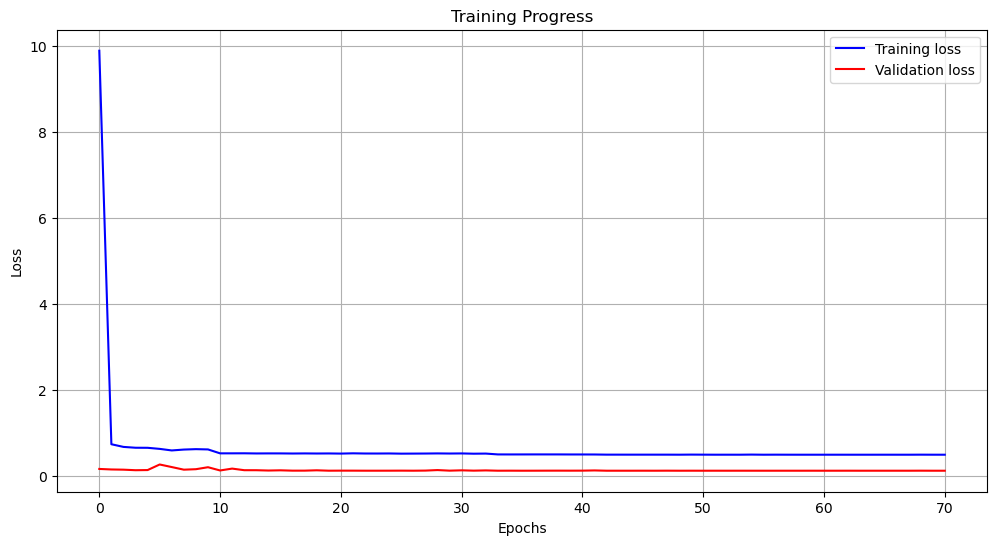

In [134]:
run_training(model=model, n_epochs=n_epochs, dataloader_train=dataloader_train, dataloader_val=dataloader_val,
             step_scheduler_step_size=step_scheduler_step_size, plateau_scheduler_factor=plateau_scheduler_factor, scheduler_to_use=scheduler_to_use,
             initial_learning_rate=initial_learning_rate,
             device=device, loss_criterion=loss_criterion,
             early_stopping_patience=early_stopping_patience
             )

### Model Inference
Now we test the model for actual predictions.

In [135]:
train_predictions = model.predict(dataloader_train, device=device)
val_predictions = model.predict(dataloader_val, device=device)

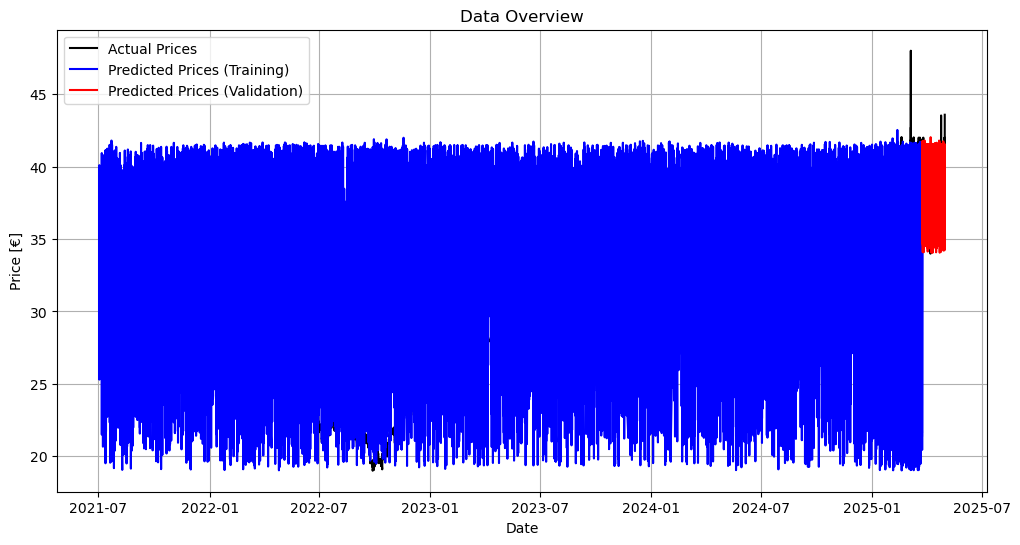

In [136]:
# plot result:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(dates, normaliser.inverse_transform(Y), label='Actual Prices', color='black')
ax.plot(dates_train, normaliser.inverse_transform(train_predictions), label='Predicted Prices (Training)', color='blue')
ax.plot(dates_val, normaliser.inverse_transform(val_predictions), label='Predicted Prices (Validation)', color='red')

ax.set_xlabel('Date')
ax.set_ylabel('Price [€]')
ax.set_title('Data Overview')
ax.grid(True)
ax.legend()

Narrower view:

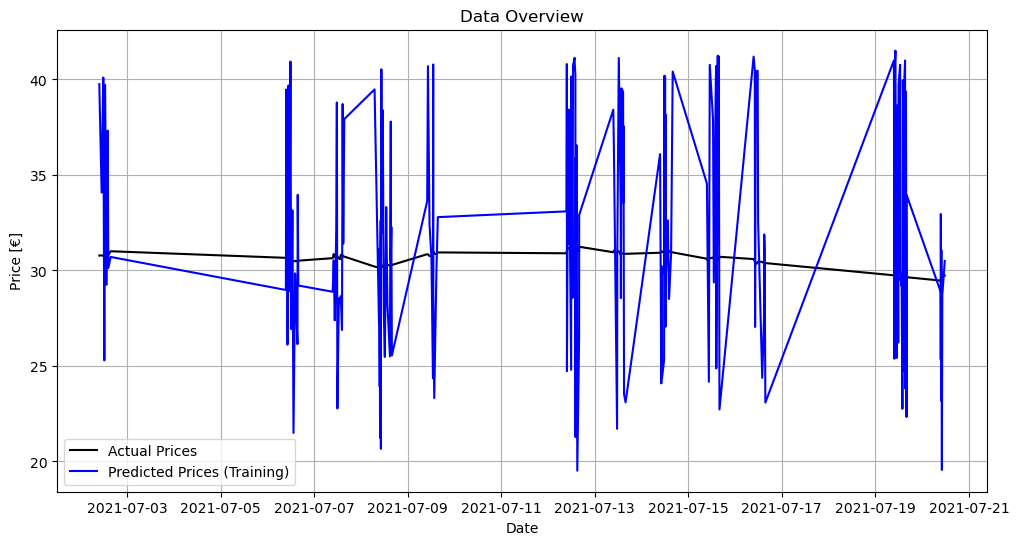

In [137]:
days_to_scrutinize = 200

# plot result:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(dates_train[:days_to_scrutinize], normaliser.inverse_transform(Y_train[:days_to_scrutinize]), label='Actual Prices', color='black')
#ax.plot(dates_train, normaliser.inverse_transform(train_predictions), label='Predicted Prices (Training)', color='blue')
ax.plot(dates_train[:days_to_scrutinize], normaliser.inverse_transform(train_predictions[:days_to_scrutinize]), label='Predicted Prices (Training)', color='blue')

ax.set_xlabel('Date')
ax.set_ylabel('Price [€]')
ax.set_title('Data Overview')
ax.grid(True)
ax.legend()

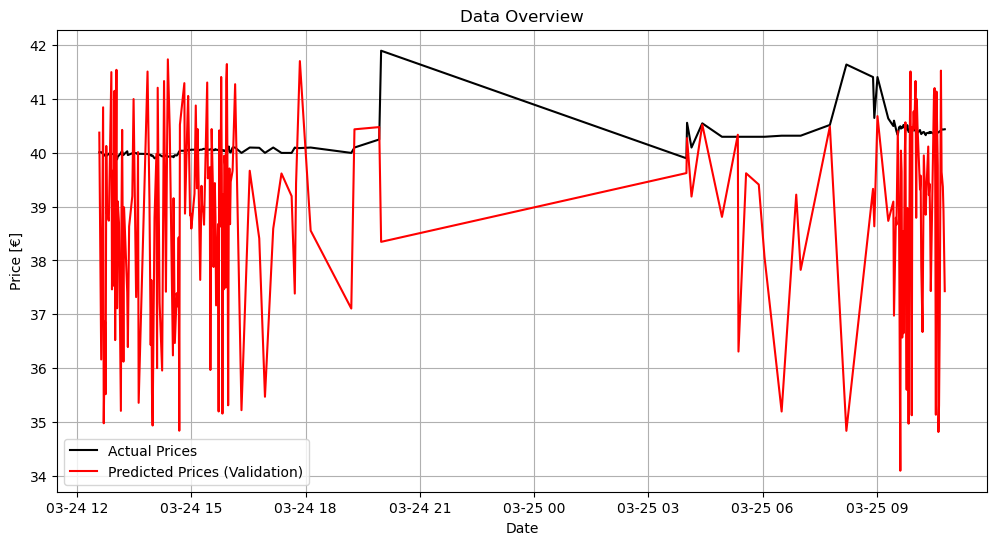

In [138]:
days_to_scrutinize = 200

# plot result:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(dates_val[:days_to_scrutinize], normaliser.inverse_transform(Y_val[:days_to_scrutinize]), label='Actual Prices', color='black')
#ax.plot(dates_train, normaliser.inverse_transform(train_predictions), label='Predicted Prices (Training)', color='blue')
ax.plot(dates_val[:days_to_scrutinize], normaliser.inverse_transform(val_predictions[:days_to_scrutinize]), label='Predicted Prices (Validation)', color='red')

ax.set_xlabel('Date')
ax.set_ylabel('Price [€]')
ax.set_title('Data Overview')
ax.grid(True)
ax.legend()